<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/basics_05_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# BOILER PLATE

!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

--2025-07-03 23:02:33--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-03 23:02:33 (5.99 MB/s) - ‘names.txt’ saved [228145/228145]



In [114]:
words = open('names.txt', 'r').read().splitlines()

# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)


# build the dataset
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [131]:
class Linear:
  def __init__(self,fan_in, fan_out, bias=True):
    self.weight = torch.randn(fan_in, fan_out) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out =  x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class Batch1DNorm:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.training = True
    self.momentum = momentum
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      else:
        raise ValueError(f"Unsupported input shape {x.shape}")
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.running_mean * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.running_mean * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [132]:
seed = 42
torch.manual_seed(seed)

In [133]:
n_embd = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum((p.nelement() for p in parameters)))
for p in parameters:
  p.requires_grad = True

170897


In [134]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    break

      0/ 200000: 3.3050


In [135]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 1

In [136]:
# Switch state to use running_mean/var for inference
for layer in model.layers:
  layer.training = False

In [137]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.282651662826538
val 3.2833714485168457


In [138]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

xipypzbbvcgnveufxbcwlvohrlnjhelg.
msmaqiunvuvrmmkfvmomvg.
dktfwvkelblgrxfol.
jdnsdwkpmljxbrwxntdufbzi.
uuvjcwownaemaczf.
xkpodpjalpqfaevnykae.
utvubi.
ehhuzjduwlq.
lvlmublkyadpksknplgluaimamqgzqd.
juuazrdywprtnlgmekh.
pxpjeelmkyyako.
itxaqkzhfikdi.
ghcci.
adectwvkqrcvz.
ebkcpwj.
pslknzdezadpjcqr.
nwicobmmala.
upczihsuci.
q.
dqg.


In [139]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (1, 8, 10)
FlattenConsecutive : (1, 4, 20)
Linear : (1, 4, 200)
Batch1DNorm : (1, 4, 200)
Tanh : (1, 4, 200)
FlattenConsecutive : (1, 2, 400)
Linear : (1, 2, 200)
Batch1DNorm : (1, 2, 200)
Tanh : (1, 2, 200)
FlattenConsecutive : (1, 400)
Linear : (1, 200)
Batch1DNorm : (1, 200)
Tanh : (1, 200)
Linear : (1, 27)


layer 4 (      Tanh): mean +0.05, std 0.71, saturated: 12.12%
layer 8 (      Tanh): mean +0.03, std 0.52, saturated: 1.25%
layer 12 (      Tanh): mean -0.02, std 0.48, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

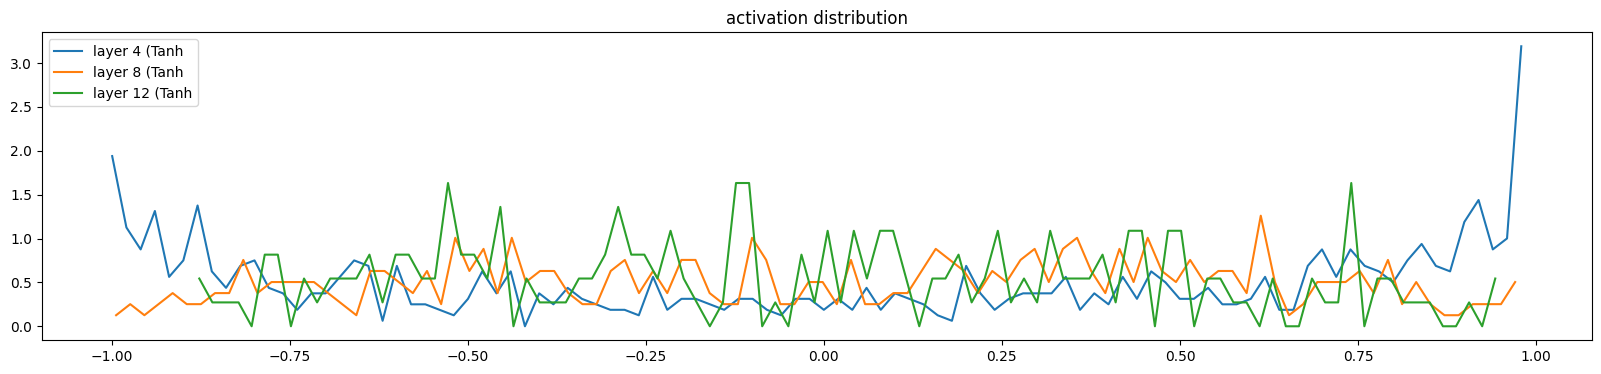

In [140]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [141]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

/tmp/ipython-input-141-153360457.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (27, 10) | mean +0.000000 | std 7.317477e-04 | grad:data ratio 7.311269e-04
weight  (20, 200) | mean +0.000008 | std 1.161333e-03 | grad:data ratio 5.200144e-03
weight (400, 200) | mean +0.000001 | std 1.028666e-03 | grad:data ratio 2.045988e-02
weight (400, 200) | mean +0.000006 | std 8.918458e-04 | grad:data ratio 1.780486e-02
weight  (200, 27) | mean -0.000000 | std 2.223545e-02 | grad:data ratio 2.977952e+00


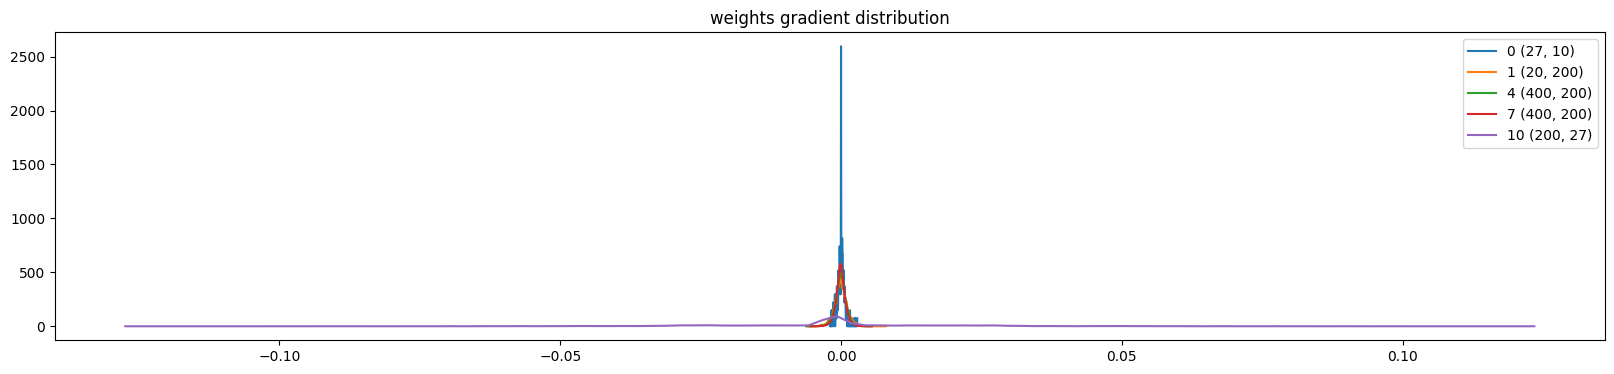

In [144]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

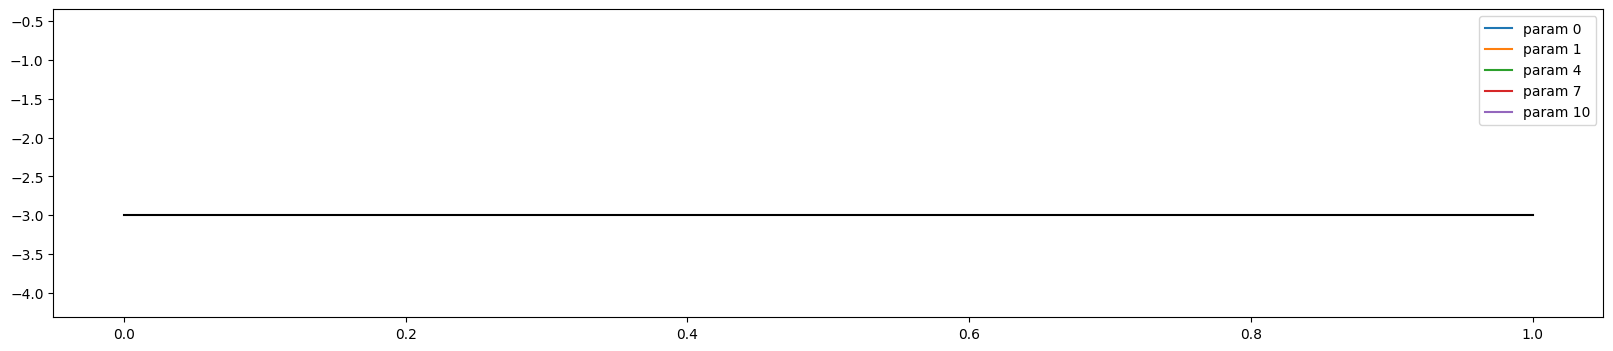

In [145]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);